# Preamble

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
# import imageio_ffmpeg
import pandas as pd
from pathlib import Path
import seaborn as sns
import time
import itertools

# %load_ext autoreload
# %autoreload 2

from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_2d_square, create_2d_square_structured
from scipy.integrate import solve_ivp
from solver import get_n_element_operators, AdvectionIVPSolver2D

from utils import u_exact_hill, u_exact_hill_dt, f_rhs_hill, advection_velocity_field, get_boundary_normal

In [2]:
sns.set_theme(style="whitegrid", context="paper")

EXPORT_DPI = 1200
ASSIGNMENT_DIR = Path().resolve()
OUTPUT_DIR = ASSIGNMENT_DIR / "report" / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Solver parameters
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)

# Problem parameterss
X_0, Y_0 = -0.75, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 5.0


for mesh_size in np.linspace(0.20, 0.29, 5):
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    print(f"K: {mesh.num_elements}, {mesh_size=}")


K: 212, mesh_size=np.float64(0.2)
K: 173, mesh_size=np.float64(0.2225)
K: 146, mesh_size=np.float64(0.245)
K: 122, mesh_size=np.float64(0.26749999999999996)
K: 117, mesh_size=np.float64(0.29)


In [ ]:
Ns = np.arange(2, 9)
# mesh_sizes = np.linspace(0.15, 0.29, 8)
mesh_sizes = np.linspace(0.20, 0.29, 5)

convergence_data = []
for N, mesh_size in tqdm(itertools.product(Ns, mesh_sizes)):
    print(f"Running simulation for N={N}, mesh_size={mesh_size}...")
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    d_ele = create_discretization_element(N)
    d_mesh = create_discretization_mesh(mesh, d_ele)

    solver = AdvectionIVPSolver2D(
        mesh=mesh,
        discretization_element=d_ele,
        discretization_mesh=d_mesh,
        advection_velocity_field=advection_velocity_field,
        g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        f_rhs=f_rhs_hill,
    )

    u0 = u_exact_hill(
        d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0
    )

    t_span = (t_start, t_final)
    t_eval = [t_final]

    t_cpu_start = time.perf_counter()
    sol = solve_ivp(
        fun=solver.get_rhs_IVP,
        t_span=t_span,
        y0=u0,
        t_eval=t_eval,
        method="RK45",
    )
    t_cpu_total = time.perf_counter() - t_cpu_start

    if not sol.success:
        raise ValueError("Solver failed!")

    final_sol = sol.y.T[-1]
    exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
    error = final_sol - exact_sol
    L2_err = np.sqrt(error @ (solver.M_global @ error))
    Linf_err = np.max(np.abs(error))

    convergence_data.append({
        "N": N,
        "mesh_size": mesh_size,
        "K": mesh.num_elements,
        "L2_error": L2_err,
        "Linf_error": Linf_err,
        "num_elements": mesh.num_elements,
        "sol": final_sol,
        "exact_sol": exact_sol,
        "nfev": sol.nfev,
        "time_total": t_cpu_total,
    })


0it [00:00, ?it/s]

Running simulation for N=2, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 13250.96it/s]
1it [00:01,  1.62s/it]

Running simulation for N=2, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 9923.34it/s]
2it [00:02,  1.46s/it]

Running simulation for N=2, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 6805.98it/s]
3it [00:04,  1.37s/it]

Running simulation for N=2, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 13554.74it/s]
4it [00:05,  1.28s/it]

Running simulation for N=2, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 9079.76it/s]
5it [00:07,  1.44s/it]

Running simulation for N=3, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 9683.13it/s]
6it [00:10,  2.08s/it]

Running simulation for N=3, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 7970.63it/s]
7it [00:12,  2.21s/it]

Running simulation for N=3, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 5899.16it/s]
8it [00:14,  2.11s/it]

Running simulation for N=3, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 12202.92it/s]
9it [00:16,  1.96s/it]

Running simulation for N=3, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 10636.44it/s]
10it [00:18,  1.86s/it]

Running simulation for N=4, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 8832.13it/s]
11it [00:23,  2.89s/it]

Running simulation for N=4, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 8436.10it/s]
12it [00:27,  3.43s/it]

Running simulation for N=4, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 10995.23it/s]
13it [00:31,  3.33s/it]

Running simulation for N=4, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 6744.05it/s]
14it [00:33,  3.16s/it]

Running simulation for N=4, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 10639.21it/s]
15it [00:36,  3.01s/it]

Running simulation for N=5, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 2681.94it/s]
16it [00:45,  4.88s/it]

Running simulation for N=5, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 5965.95it/s]
17it [00:53,  5.62s/it]

Running simulation for N=5, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 6481.53it/s]
18it [00:59,  5.78s/it]

Running simulation for N=5, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 7515.68it/s]
19it [01:04,  5.67s/it]

Running simulation for N=5, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 6497.97it/s]
20it [01:09,  5.47s/it]

Running simulation for N=6, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 2883.90it/s]
21it [01:36, 11.99s/it]

Running simulation for N=6, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 3717.80it/s]
22it [01:51, 12.90s/it]

Running simulation for N=6, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 3695.07it/s]
23it [02:04, 12.84s/it]

Running simulation for N=6, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 4771.05it/s]
24it [02:13, 11.79s/it]

Running simulation for N=6, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 4533.88it/s]
25it [02:21, 10.58s/it]

Running simulation for N=7, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 2555.25it/s]
26it [03:08, 21.49s/it]

Running simulation for N=7, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 2512.72it/s]
27it [03:48, 27.13s/it]

Running simulation for N=7, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 1611.53it/s]
28it [04:19, 28.18s/it]

Running simulation for N=7, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 2642.41it/s]
29it [04:40, 25.99s/it]

Running simulation for N=7, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 2720.60it/s]
30it [04:59, 23.96s/it]

Running simulation for N=8, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 1644.06it/s]
31it [06:40, 46.99s/it]

Running simulation for N=8, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 1443.44it/s]
32it [08:01, 57.23s/it]

Running simulation for N=8, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 1497.78it/s]
33it [09:09, 60.59s/it]

Running simulation for N=8, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 1831.43it/s]
34it [09:53, 55.47s/it]

Running simulation for N=8, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 1931.12it/s]
35it [10:38, 18.25s/it]


[]

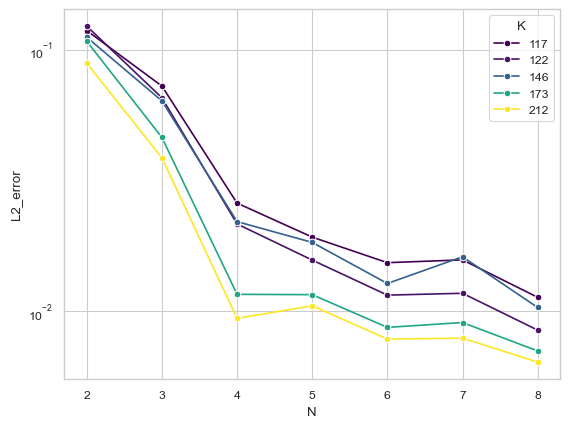

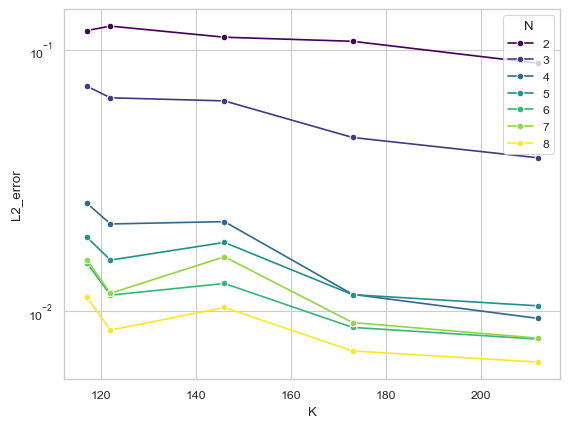

In [5]:
df = pd.DataFrame(convergence_data)
# sns.lineplot(data=df, x="mesh_size", y="L2_error", hue="N", marker="o")
plt.figure()
sns.lineplot(data=df, x="N", y="L2_error", hue="K", marker="o", palette="viridis")
plt.semilogy()
#---
plt.figure()
sns.lineplot(data=df, x="K", y="L2_error", hue="N", marker="o", palette="viridis")
plt.semilogy()